# Projet 7 : Implémenter un modèle de scoring

"Prêt à dépenser" est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

- L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

- De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

- Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

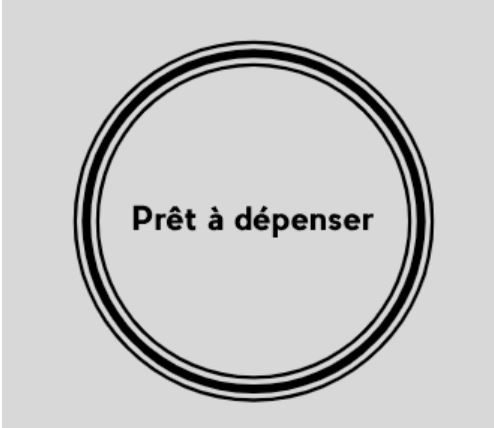

In [1]:
#!pip install imblearn

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')
import gc
import time
from contextlib import contextmanager
from collections import Counter

#Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import make_pipeline 



#To balance classes
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

#ML classifier
from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.model_selection import ParameterGrid, ParameterSampler

from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier



# Evaluation metrics for classification
from sklearn.metrics import  confusion_matrix, classification_report, roc_curve, make_scorer
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score, roc_auc_score, accuracy_score

from tqdm import tqdm

#les versions??

In [3]:
from xgboost import XGBClassifier

In [4]:
# Display option
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

In [5]:
path = 'C:/Users/betas/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/'


In [6]:
#Path of csv files
path = 'C:/Users/betas/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/'

# to read files
application_test = pd.read_csv(path + 'application_test.csv')
application_train = pd.read_csv(path + 'application_train.csv')
bureau = pd.read_csv(path + 'bureau.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
HomeCredit_columns_description = pd.read_csv(path + 'HomeCredit_columns_description.csv', nrows=250)
installments_payments = pd.read_csv(path + 'installments_payments.csv')
POS_CASH_balance = pd.read_csv(path + 'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

# EDA
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

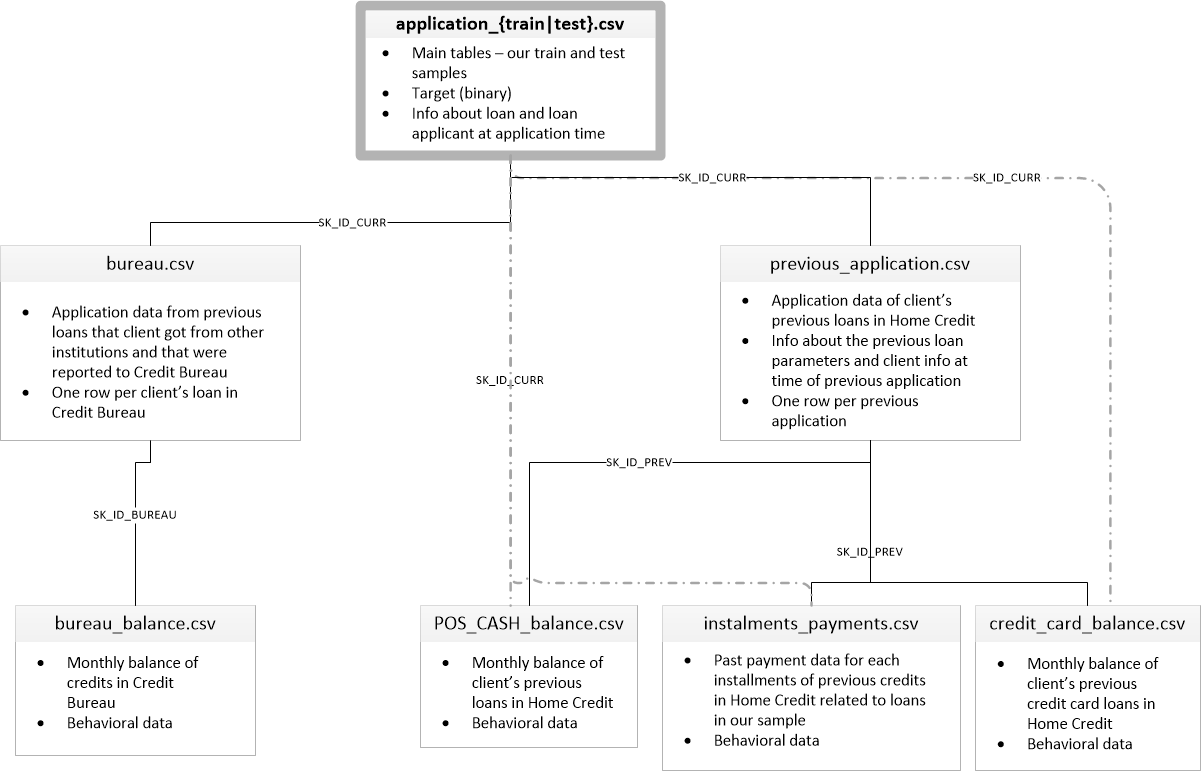

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan.




**-application_{train|test} :**
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**-bureau :**
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.


**-bureau_balance :**
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


**-POS_CASH_balance :**
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.


**-credit_card_balance :**
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


**-previous_application :**
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.


**-installments_payments :**
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


**-HomeCredit_columns_description :**
This file contains descriptions for the columns in the various data files.

**-sample_submission :** 

In [7]:
def data_info(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("SUMMARY FILES…")
    return(comparative_table)

In [8]:
#data_info(folder = glob.glob('C:/Users/betas/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/*.csv'))

In [9]:
#Variables understanding
#HomeCredit_columns_description

In [10]:
# Type and missing values statistics of variables
#Create a dataframe containing the amont of missing values & type of each variable
def data_description(df) :
    column_list    = []
    variable_type  = []
    unique_list    = []
    missing_values = []
    shape_list     = []
    
    for col in df.columns :
        column_list.append(col)
        variable_type.append(df[col].dtype)
        unique_list.append(df[col].nunique())
        missing_values.append(df[col].isna().mean()*100)        
    
    resume_data = pd.DataFrame([column_list, variable_type, unique_list, missing_values]).T
    resume_data.columns = ['column name', 'Var type', 'unique values', '% missing values']
   
    return resume_data.sort_values(by='% missing values')

#Create a dictionnary of dataframe
dict_df = {
    'application_train'     : application_train,  
    'application_test'     : application_test,   
    'bureau'                : bureau,
    'bureau_balance'        : bureau_balance,
    'credit_card_balance'   : credit_card_balance,
    'installments_payments' : installments_payments,
    'POS_CASH_balance'      : POS_CASH_balance,
    'previous_application'  : previous_application,
    'sample_submission'     : sample_submission
          }
    
for df_name, df in dict_df.items():
    print('_____________{}_____________'.format(df_name))
    print ('the shape of {} table is {}'.format(df_name, df.shape))
    display(data_description(df))

_____________application_train_____________
the shape of application_train table is (307511, 122)


column name Var type unique values % missing values
0                      SK_ID_CURR    int64        307511              0.0
33        HOUR_APPR_PROCESS_START    int64            24              0.0
35     REG_REGION_NOT_WORK_REGION    int64             2              0.0
36    LIVE_REGION_NOT_WORK_REGION    int64             2              0.0
37         REG_CITY_NOT_LIVE_CITY    int64             2              0.0
38         REG_CITY_NOT_WORK_CITY    int64             2              0.0
39        LIVE_CITY_NOT_WORK_CITY    int64             2              0.0
40              ORGANIZATION_TYPE   object            58              0.0
115              FLAG_DOCUMENT_21    int64             2              0.0
114              FLAG_DOCUMENT_20    int64             2              0.0
113              FLAG_DOCUMENT_19    int64             2              0.0
112              FLAG_DOCUMENT_18    int64             2              0.0
111              FLAG_DOCUMENT_17    int64             2              0.0
110              FLAG_DOCUMENT_16    int64             2              0.0
109              FLAG_DOCUMENT_15    int64             2              0.0
108              FLAG_DOCUMENT_14    int64             2              0.0
107              FLAG_DOCUMENT_13    int64             2              0.0
106              FLAG_DOCUMENT_12    int64             2              0.0
105              FLAG_DOCUMENT_11    int64             2              0.0
104              FLAG_DOCUMENT_10    int64             2              0.0
103               FLAG_DOCUMENT_9    int64             2              0.0
102               FLAG_DOCUMENT_8    int64             2              0.0
101               FLAG_DOCUMENT_7    int64             2              0.0
100               FLAG_DOCUMENT_6    int64             2              0.0
99                FLAG_DOCUMENT_5    int64             2              0.0
98                FLAG_DOCUMENT_4    int64             2              0.0
97                FLAG_DOCUMENT_3    int64             2              0.0
96                FLAG_DOCUMENT_2    int64             2              0.0
32     WEEKDAY_APPR_PROCESS_START   object             7              0.0
31    REGION_RATING_CLIENT_W_CITY    int64             3              0.0
34     REG_REGION_NOT_LIVE_REGION    int64             2              0.0
15              NAME_HOUSING_TYPE   object             6              0.0
6                    CNT_CHILDREN    int64            15              0.0
12               NAME_INCOME_TYPE   object             8              0.0
13            NAME_EDUCATION_TYPE   object             5              0.0
14             NAME_FAMILY_STATUS   object             6              0.0
30           REGION_RATING_CLIENT    int64             3              0.0
16     REGION_POPULATION_RELATIVE  float64            81              0.0
17                     DAYS_BIRTH    int64         17460              0.0
18                  DAYS_EMPLOYED    int64         12574              0.0
19              DAYS_REGISTRATION  float64         15688              0.0
20                DAYS_ID_PUBLISH    int64          6168              0.0
7                AMT_INCOME_TOTAL  float64          2548              0.0
5                 FLAG_OWN_REALTY   object             2              0.0
3                     CODE_GENDER   object             3              0.0
2              NAME_CONTRACT_TYPE   object             2              0.0
22                     FLAG_MOBIL    int64             2              0.0
23                 FLAG_EMP_PHONE    int64             2              0.0
24                FLAG_WORK_PHONE    int64             2              0.0
25               FLAG_CONT_MOBILE    int64             2              0.0
26                     FLAG_PHONE    int64             2              0.0
1                          TARGET    int64             2              0.0
27                     FLAG_EMAIL    int64             2              0.0
4                    FLAG_

_____________application_test_____________
the shape of application_test table is (48744, 121)


column name Var type unique values % missing values
0                      SK_ID_CURR    int64         48744              0.0
34     REG_REGION_NOT_WORK_REGION    int64             2              0.0
35    LIVE_REGION_NOT_WORK_REGION    int64             2              0.0
36         REG_CITY_NOT_LIVE_CITY    int64             2              0.0
37         REG_CITY_NOT_WORK_CITY    int64             2              0.0
38        LIVE_CITY_NOT_WORK_CITY    int64             2              0.0
39              ORGANIZATION_TYPE   object            58              0.0
114              FLAG_DOCUMENT_21    int64             1              0.0
113              FLAG_DOCUMENT_20    int64             1              0.0
112              FLAG_DOCUMENT_19    int64             1              0.0
111              FLAG_DOCUMENT_18    int64             2              0.0
110              FLAG_DOCUMENT_17    int64             1              0.0
109              FLAG_DOCUMENT_16    int64             1              0.0
108              FLAG_DOCUMENT_15    int64             1              0.0
107              FLAG_DOCUMENT_14    int64             1              0.0
106              FLAG_DOCUMENT_13    int64             1              0.0
105              FLAG_DOCUMENT_12    int64             1              0.0
104              FLAG_DOCUMENT_11    int64             2              0.0
103              FLAG_DOCUMENT_10    int64             1              0.0
102               FLAG_DOCUMENT_9    int64             2              0.0
101               FLAG_DOCUMENT_8    int64             2              0.0
100               FLAG_DOCUMENT_7    int64             2              0.0
99                FLAG_DOCUMENT_6    int64             2              0.0
98                FLAG_DOCUMENT_5    int64             2              0.0
97                FLAG_DOCUMENT_4    int64             2              0.0
96                FLAG_DOCUMENT_3    int64             2              0.0
95                FLAG_DOCUMENT_2    int64             1              0.0
94         DAYS_LAST_PHONE_CHANGE  float64          3579              0.0
32        HOUR_APPR_PROCESS_START    int64            24              0.0
31     WEEKDAY_APPR_PROCESS_START   object             7              0.0
33     REG_REGION_NOT_LIVE_REGION    int64             2              0.0
29           REGION_RATING_CLIENT    int64             3              0.0
1              NAME_CONTRACT_TYPE   object             2              0.0
2                     CODE_GENDER   object             2              0.0
3                    FLAG_OWN_CAR   object             2              0.0
4                 FLAG_OWN_REALTY   object             2              0.0
5                    CNT_CHILDREN    int64            11              0.0
6                AMT_INCOME_TOTAL  float64           606              0.0
7                      AMT_CREDIT  float64          2937              0.0
9                 AMT_GOODS_PRICE  float64           677              0.0
11               NAME_INCOME_TYPE   object             7              0.0
12            NAME_EDUCATION_TYPE   object             5              0.0
13             NAME_FAMILY_STATUS   object             5              0.0
14              NAME_HOUSING_TYPE   object             6              0.0
30    REGION_RATING_CLIENT_W_CITY    int64             4              0.0
16                     DAYS_BIRTH    int64         15477              0.0
17                  DAYS_EMPLOYED    int64          7863              0.0
15     REGION_POPULATION_RELATIVE  float64            81              0.0
19                DAYS_ID_PUBLISH    int64          5880              0.0
28                CNT_FAM_MEMBERS  float64            12              0.0
26                     FLAG_EMAIL    int64             2              0.0
25                     FLAG_PHONE    int64             2              0.0
24               FLAG_CONT_MOBILE    int64             2              0.0
18              DAYS_REGIS

_____________bureau_____________
the shape of bureau table is (1716428, 17)


column name Var type unique values % missing values
0               SK_ID_CURR    int64        305811              0.0
1             SK_ID_BUREAU    int64       1716428              0.0
2            CREDIT_ACTIVE   object             4              0.0
3          CREDIT_CURRENCY   object             4              0.0
4              DAYS_CREDIT    int64          2923              0.0
5       CREDIT_DAY_OVERDUE    int64           942              0.0
15      DAYS_CREDIT_UPDATE    int64          2982              0.0
9       CNT_CREDIT_PROLONG    int64            10              0.0
13  AMT_CREDIT_SUM_OVERDUE  float64          1616              0.0
14             CREDIT_TYPE   object            15              0.0
10          AMT_CREDIT_SUM  float64        236708         0.000757
6      DAYS_CREDIT_ENDDATE  float64         14096         6.149573
11     AMT_CREDIT_SUM_DEBT  float64        226537        15.011932
12    AMT_CREDIT_SUM_LIMIT  float64         51726        34.477415
7        DAYS_ENDDATE_FACT  float64          2917        36.916958
8   AMT_CREDIT_MAX_OVERDUE  float64         68251        65.513264
16             AMT_ANNUITY  float64         40321         71.47349

_____________bureau_balance_____________
the shape of bureau_balance table is (27299925, 3)


column name Var type unique values % missing values
0    SK_ID_BUREAU    int64        817395              0.0
1  MONTHS_BALANCE    int64            97              0.0
2          STATUS   object             8              0.0

_____________credit_card_balance_____________
the shape of credit_card_balance table is (3840312, 23)


column name Var type unique values % missing values
0                   SK_ID_PREV    int64        104307              0.0
20        NAME_CONTRACT_STATUS   object             7              0.0
16        CNT_DRAWINGS_CURRENT    int64           129              0.0
14        AMT_TOTAL_RECEIVABLE  float64       1339008              0.0
13               AMT_RECIVABLE  float64       1338878              0.0
12    AMT_RECEIVABLE_PRINCIPAL  float64       1195839              0.0
21                      SK_DPD    int64           917              0.0
11   AMT_PAYMENT_TOTAL_CURRENT  float64        182957              0.0
6         AMT_DRAWINGS_CURRENT  float64        187005              0.0
4      AMT_CREDIT_LIMIT_ACTUAL    int64           181              0.0
3                  AMT_BALANCE  float64       1347904              0.0
2               MONTHS_BALANCE    int64            96              0.0
1                   SK_ID_CURR    int64        103558              0.0
22                  SK_DPD_DEF    int64           378              0.0
9      AMT_INST_MIN_REGULARITY  float64        312266         7.948208
19   CNT_INSTALMENT_MATURE_CUM  float64           121         7.948208
8     AMT_DRAWINGS_POS_CURRENT  float64        168748        19.524872
5     AMT_DRAWINGS_ATM_CURRENT  float64          2267        19.524872
15    CNT_DRAWINGS_ATM_CURRENT  float64            44        19.524872
17  CNT_DRAWINGS_OTHER_CURRENT  float64            11        19.524872
18    CNT_DRAWINGS_POS_CURRENT  float64           133        19.524872
7   AMT_DRAWINGS_OTHER_CURRENT  float64          1832        19.524872
10         AMT_PAYMENT_CURRENT  float64        163209        19.998063

_____________installments_payments_____________
the shape of installments_payments table is (13605401, 8)


column name Var type unique values % missing values
0              SK_ID_PREV    int64        997752              0.0
1              SK_ID_CURR    int64        339587              0.0
2  NUM_INSTALMENT_VERSION  float64            65              0.0
3   NUM_INSTALMENT_NUMBER    int64           277              0.0
4         DAYS_INSTALMENT  float64          2922              0.0
6          AMT_INSTALMENT  float64        902539              0.0
5      DAYS_ENTRY_PAYMENT  float64          3039         0.021352
7             AMT_PAYMENT  float64        944235         0.021352

_____________POS_CASH_balance_____________
the shape of POS_CASH_balance table is (10001358, 8)


column name Var type unique values % missing values
0             SK_ID_PREV    int64        936325              0.0
1             SK_ID_CURR    int64        337252              0.0
2         MONTHS_BALANCE    int64            96              0.0
5   NAME_CONTRACT_STATUS   object             9              0.0
6                 SK_DPD    int64          3400              0.0
7             SK_DPD_DEF    int64          2307              0.0
3         CNT_INSTALMENT  float64            73         0.260675
4  CNT_INSTALMENT_FUTURE  float64            79         0.260835

_____________previous_application_____________
the shape of previous_application table is (1670214, 37)


column name Var type unique values % missing values
0                    SK_ID_PREV    int64       1670214              0.0
29             NAME_YIELD_GROUP   object             5              0.0
27         NAME_SELLER_INDUSTRY   object            11              0.0
26             SELLERPLACE_AREA    int64          2097              0.0
25                 CHANNEL_TYPE   object             8              0.0
24            NAME_PRODUCT_TYPE   object             3              0.0
23               NAME_PORTFOLIO   object             5              0.0
22          NAME_GOODS_CATEGORY   object            28              0.0
21             NAME_CLIENT_TYPE   object             4              0.0
19           CODE_REJECT_REASON   object             9              0.0
17                DAYS_DECISION    int64          2922              0.0
16         NAME_CONTRACT_STATUS   object             4              0.0
15       NAME_CASH_LOAN_PURPOSE   object            25              0.0
18            NAME_PAYMENT_TYPE   object             4              0.0
4               AMT_APPLICATION  float64         93885              0.0
11       NFLAG_LAST_APPL_IN_DAY    int64             2              0.0
10  FLAG_LAST_APPL_PER_CONTRACT   object             2              0.0
9       HOUR_APPR_PROCESS_START    int64            24              0.0
8    WEEKDAY_APPR_PROCESS_START   object             7              0.0
2            NAME_CONTRACT_TYPE   object             4              0.0
1                    SK_ID_CURR    int64        338857              0.0
5                    AMT_CREDIT  float64         86803          0.00006
30          PRODUCT_COMBINATION   object            17         0.020716
28                  CNT_PAYMENT  float64            49        22.286366
3                   AMT_ANNUITY  float64        357959        22.286665
7               AMT_GOODS_PRICE  float64         93885        23.081773
34                DAYS_LAST_DUE  float64          2873        40.298129
33    DAYS_LAST_DUE_1ST_VERSION  float64          4605        40.298129
32               DAYS_FIRST_DUE  float64          2892        40.298129
31           DAYS_FIRST_DRAWING  float64          2838        40.298129
36    NFLAG_INSURED_ON_APPROVAL  float64             2        40.298129
35             DAYS_TERMINATION  float64          2830        40.298129
20              NAME_TYPE_SUITE   object             7        49.119754
6              AMT_DOWN_PAYMENT  float64         29278         53.63648
12            RATE_DOWN_PAYMENT  float64        207033         53.63648
13        RATE_INTEREST_PRIMARY  float64           148        99.643698
14     RATE_INTEREST_PRIVILEGED  float64            25        99.643698

_____________sample_submission_____________
the shape of sample_submission table is (48744, 2)


column name Var type unique values % missing values
0  SK_ID_CURR    int64         48744              0.0
1      TARGET  float64             1              0.0

In [11]:
# To talk about missing values???

When it comes time to build our machine learning models we will have to fill in these missing values (known as imputation) or we will use models such as XGBoost that can handle missing values with no need for imputation.

Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

In [12]:
for df_name, df in dict_df.items():
    print('_____________{}_____________'.format(df_name))
    print(df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
    print('\n')

_____________application_train_____________
NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


_____________application_test_____________
NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZ

### Outliers, valeurs atypiques, anormales


In [13]:
#Description numeric variables
for df_name, df in dict_df.items() : 
    print('******************',df_name,'**********************')
    display(df.describe().T.style.background_gradient(cmap = "Blues"))

****************** application_train **********************


****************** application_test **********************


****************** bureau **********************


****************** bureau_balance **********************


****************** credit_card_balance **********************


****************** installments_payments **********************


****************** POS_CASH_balance **********************


****************** previous_application **********************


****************** sample_submission **********************


Les nombres de la colonne DAYS_BIRTH et DAYS_EMPLOYED sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Il est nécessaire de modifier cette variable pour obtenir des chiffres plus compréhensibles pour l'analyse.

# Target understanding
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In our context,

output = 1 means client will have payment difficulties

output = 0 means client will repay in time

In [14]:
HomeCredit_columns_description.iloc[1,3]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Text(0.5, 1.0, 'Target')

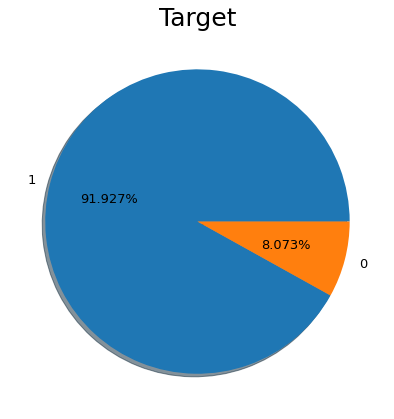

In [15]:
fig,ax = plt.subplots (figsize = (7,7))
ax.pie(
    application_train['TARGET'].value_counts(), 
    labels = application_train['TARGET'].unique(),
    shadow=True,
    autopct='%1.3f%%',
    textprops={'fontsize': 13}
      )  
plt.title ('Target' , size= 25)

92% of loans were repaid and therefore 8% of individuals were insolvent.From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

A pie plot of the dataset is created showing the large mass of points that belong to the majority class (blue) and a small number of points spread out for the minority class (orange). We can see some measure of overlap between the two classes.

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='TARGET'>

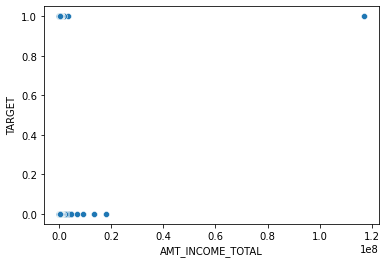

In [16]:
sns.scatterplot(x=application_train['AMT_INCOME_TOTAL'], y=application_train['TARGET'])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

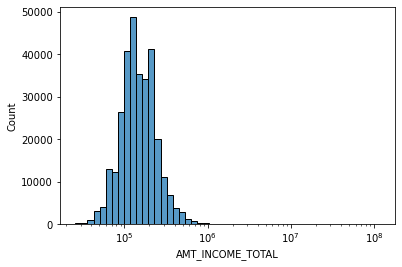

In [17]:
sns.histplot(application_train['AMT_INCOME_TOTAL'], log_scale=True, bins=50)

# features 

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

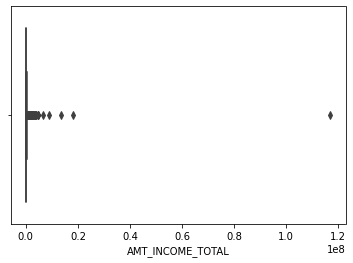

In [18]:
sns.boxplot(application_train['AMT_INCOME_TOTAL'])

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [19]:
(application_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64


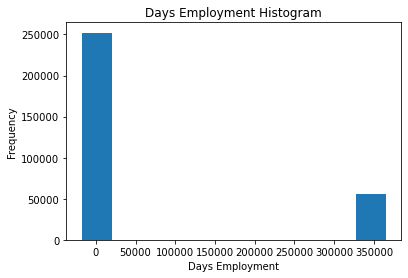

In [20]:
print((application_train['DAYS_EMPLOYED']/-365).describe())
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

hat doesn't look right! The maximum value (besides being positive) is about 1000 years!
One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning.

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

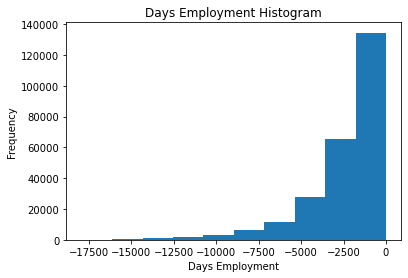

In [21]:
display(((application_train['DAYS_EMPLOYED'].replace({365243: np.nan}))/-365).describe())
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [22]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(12,5)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(12,5)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("", fontsize=15)
    #ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')



                                   -------------------------------------------------------


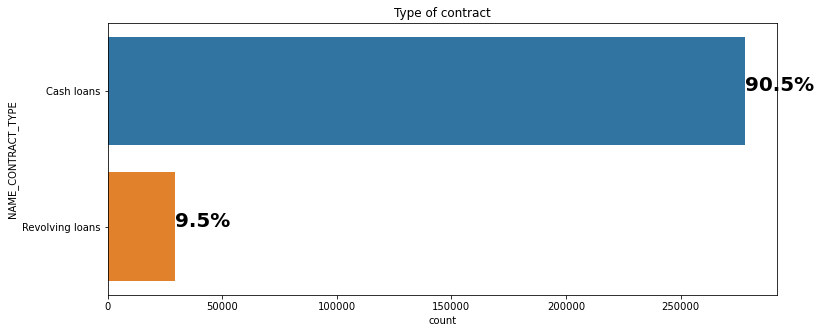

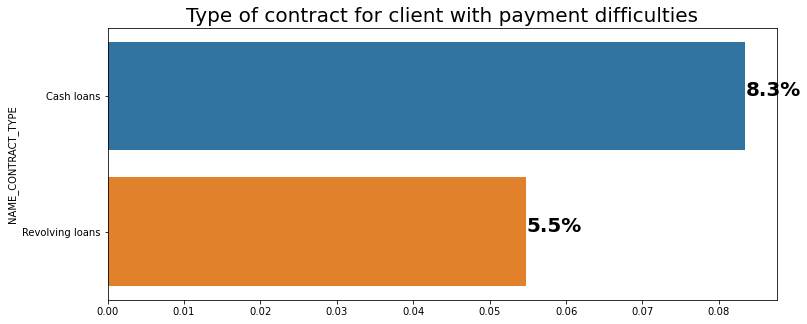

In [23]:
#NAME_CONTRACT_TYPE
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type of contract")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type of contract for client with payment difficulties")

                                   -------------------------------------------------------


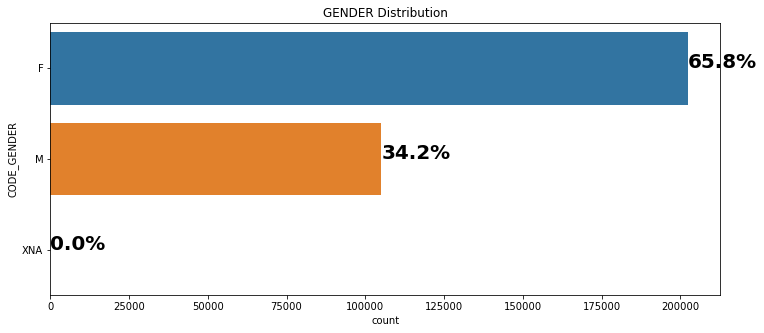

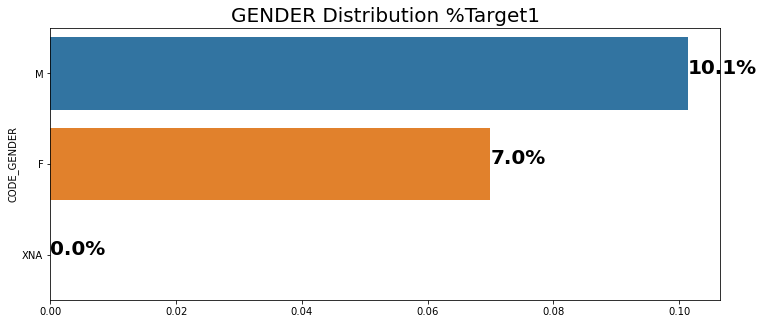

In [24]:
#CODE_GENDER
plot_stat(application_train, 'CODE_GENDER',"GENDER Distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'CODE_GENDER',"GENDER Distribution %Target1")

                                   -------------------------------------------------------


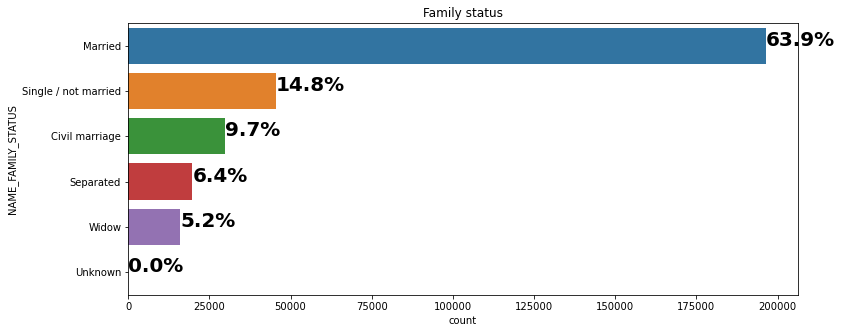

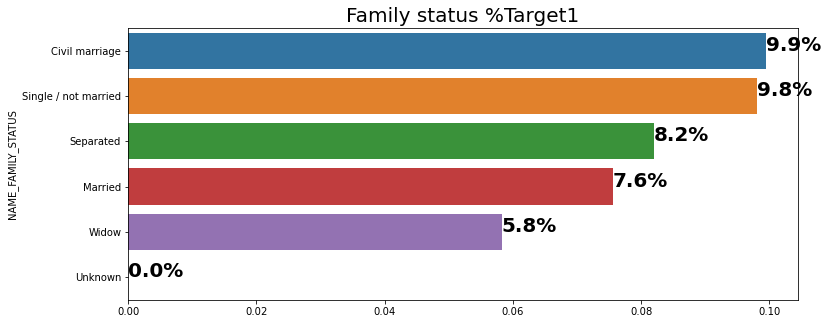

In [25]:
#NAME_FAMILY_STATUS
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Family status")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"Family status %Target1")

Most clients are married, followed by single/unmarried and civil marriages.

In terms of loan default percentage, civil marriage has the highest default percentage (10%), with widow having the lowest (excluding the unknown).

                                   -------------------------------------------------------


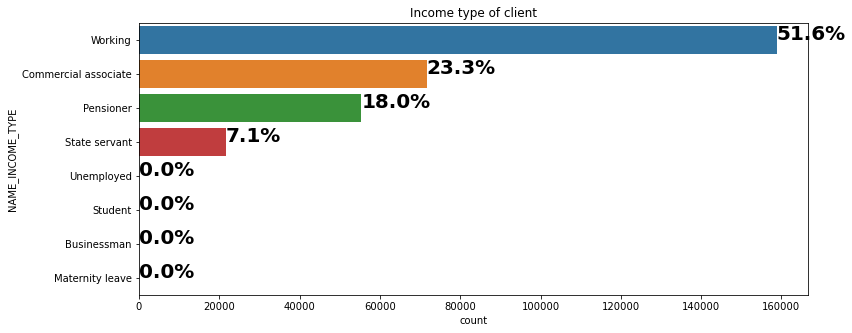

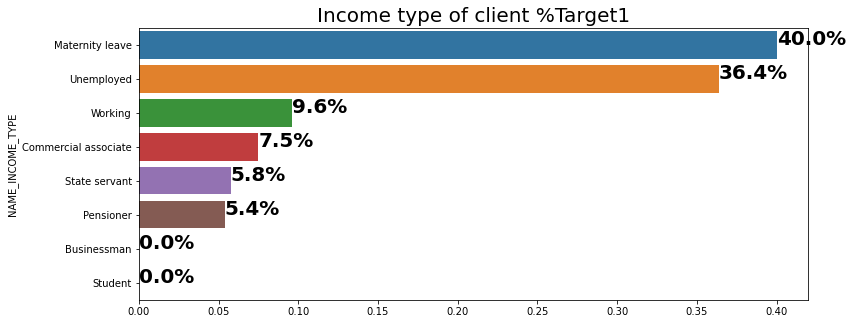

In [26]:
#NAME_INCOME_TYPE
plot_stat(application_train, 'NAME_INCOME_TYPE',"Income type of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Income type of client %Target1")

La plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.

Les demandeurs avec le type de revenu Congé de maternité ont un ratio de près de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.

                                   -------------------------------------------------------


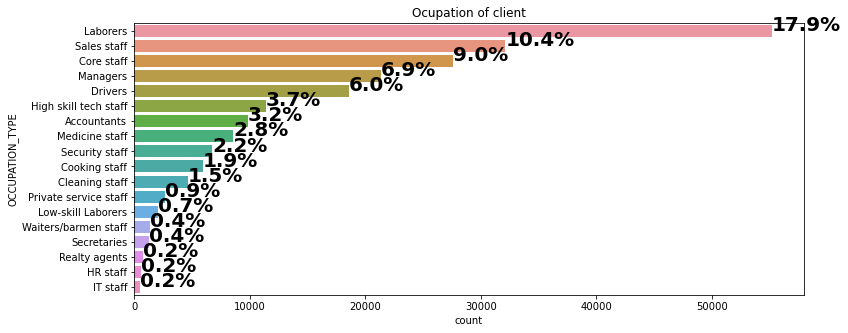

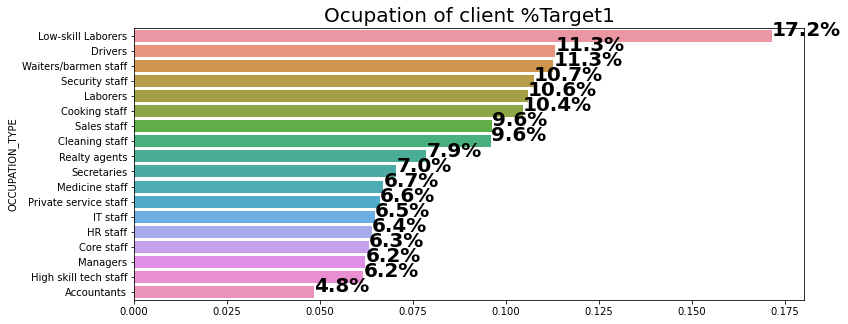

In [27]:
#OCCUPATION_TYPE
plot_stat(application_train, 'OCCUPATION_TYPE',"Ocupation of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'OCCUPATION_TYPE',"Ocupation of client %Target1")

La plupart des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux. Le personnel informatique prend le montant de prêts le plus bas.

La catégorie avec le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

                                   -------------------------------------------------------


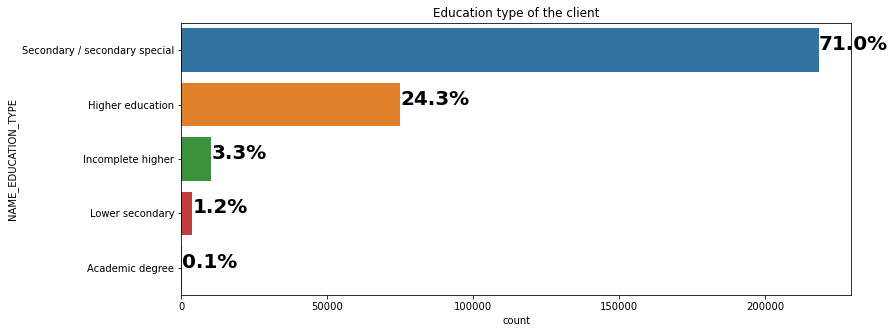

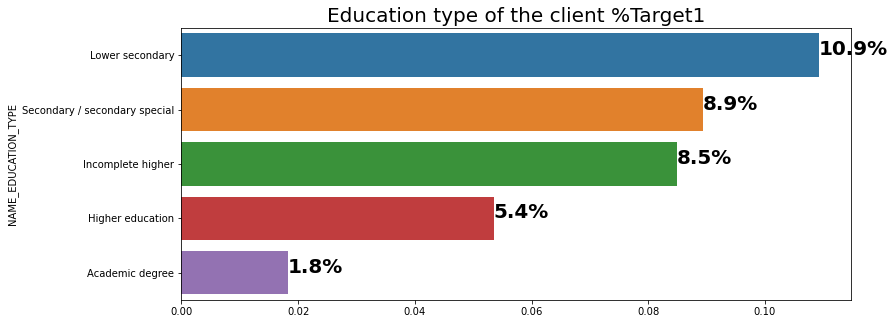

In [28]:
#NAME_EDUCATION_TYPE
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client %Target1")

La majorité des clients ont une éducation dans l'éducation secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

                                   -------------------------------------------------------


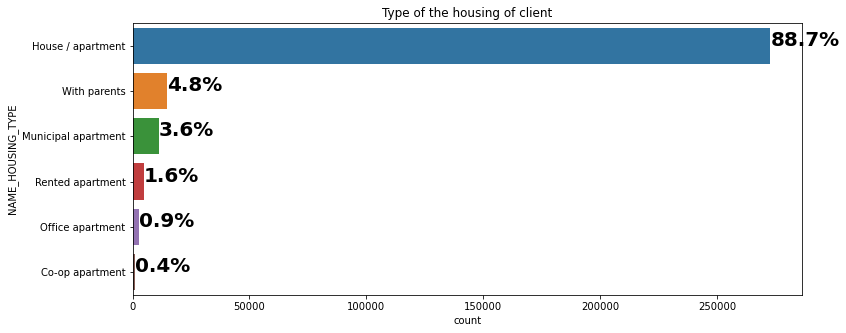

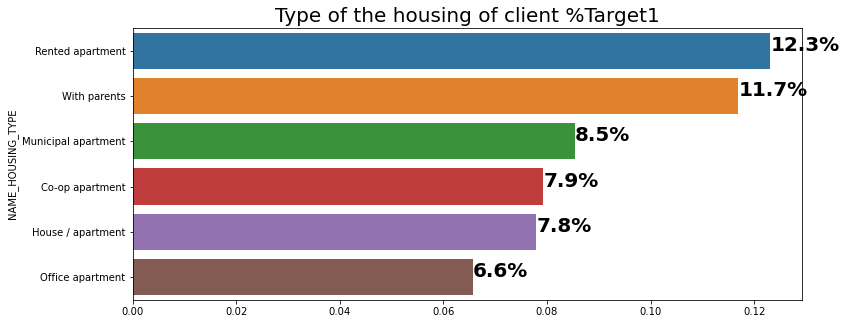

In [29]:
#NAME_HOUSING_TYPE
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client %Target1")

Plus de 250 000 demandeurs de crédits vivent en maison ou appartement. Les catégories suivantes, faible pourcentage, représentent une population moins "indépendante" (vivre chez ses parents, etc…).

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

# Preprocessing

In [30]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

def cut_cols (data, n):
    """
    To cut columns that exceed a certain amount of missing values
    args : 
        data : Pandas dataframe
        n: percentage of filling value (0<n<1)
    return :
        data : Pandas dataframe containing columns which filling amount exceed n
    
    """
    
    data = data[data.columns[(data.isna().mean()) < n]]

    return data

#########################################################################################################################

def cut_rows (data , n) :

    """
    To cut rows that exceed a certain percentage of missing values
    args : 
        data : Pandas dataframe
        n: percentage of NaN values per row (0<n<1)
    return: 
        data : Pandas dataframe containing rows which filling amount exceed ning rows which NaN amount do not
        exceed n
    """
    data = data [(data.isnull().sum(axis=1)/data.shape[1]) < n]
    return data

##########################################################################################################################

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
##########################################################################################################################

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

##########################################################################################################################

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False, flag_train=True):
    # Read data and merge
    if flag_train:
        df = pd.read_csv(path + 'application_train.csv', nrows=num_rows)
        print("Train samples: {}".format(len(df)))
    else:    
        df = pd.read_csv(path + 'application_test.csv', nrows=num_rows)
        #df = cut_cols(df , 0.4)
        print("Test samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']:#, 'EMERGENCYSTATE_MODE']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

##########################################################################################################################

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

##########################################################################################################################

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows=num_rows)
    prev = cut_cols(prev, 0.6)
    prev.drop(columns=['NAME_TYPE_SUITE'], axis=1, inplace=True)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

##########################################################################################################################

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

##########################################################################################################################
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

##########################################################################################################################

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

##########################################################################################################################

def main(debug = False, flag_train=True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows, flag_train=flag_train)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [31]:
data = main(debug=False)
data

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 23s
Previous applications df shape: (338857, 241)
Process previous_applications - done in 26s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 13s
Installments payments df shape: (339587, 26)
Process installments payments - done in 32s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0           100002       1                   0            0             0   
1           100003       0                   0            1             0   
2           100004       0                   1            0             1   
3           100006       0                   0            1             0   
4           100007       0                   0            0             0   
...            ...     ...                 ...          ...           ...   
307506      456251       0                   0            0             0   
307507      456252       0                   0            1             0   
307508      456253       0                   0            1             0   
307509      456254       1                   0            1             0   
307510      456255       0                   0            1             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     0             0          202500.0    406597.5   
1                     1             0          270000.0   1293502.5   
2                     0             0           67500.0    135000.0   
3                     0             0          135000.0    312682.5   
4                     0             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                1             0          157500.0    254700.0   
307507                0             0           72000.0    269550.0   
307508                0             0          153000.0    677664.0   
307509                0             0          171000.0    370107.0   
307510                1             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
307506      27558.0         225000.0                    0.032561       -9327   
307507      12001.5         225000.0                    0.025164      -20775   
307508      29979.0         585000.0                    0.005002      -14966   
307509      20205.0         319500.0                    0.005313      -11961   
307510      49117.5         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506         -236.0            -8456.0            -1982          NaN   
307507            NaN            -4388.0            -4090          NaN   
307508        -7921.0            -6737.0            -5150          NaN   
307509        -4786.0            -2562.0             -931          NaN   
307510        -1262.0            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4              

In [32]:
#To check infinity values
print("printing column name where infinity is present")
col_name = data.columns.to_series()[np.isinf(data).any()]
print(col_name)
print("printing row index with infinity ")  
r = data.index[np.isinf(data).any(1)]
print(r)
inf_index = data.columns.get_loc('INSTAL_PAYMENT_PERC_MAX')
data.iloc[5687,inf_index]

printing column name where infinity is present
PREV_APP_CREDIT_PERC_MAX            PREV_APP_CREDIT_PERC_MAX
PREV_APP_CREDIT_PERC_MEAN          PREV_APP_CREDIT_PERC_MEAN
REFUSED_APP_CREDIT_PERC_MAX      REFUSED_APP_CREDIT_PERC_MAX
REFUSED_APP_CREDIT_PERC_MEAN    REFUSED_APP_CREDIT_PERC_MEAN
INSTAL_PAYMENT_PERC_MAX              INSTAL_PAYMENT_PERC_MAX
INSTAL_PAYMENT_PERC_MEAN            INSTAL_PAYMENT_PERC_MEAN
INSTAL_PAYMENT_PERC_SUM              INSTAL_PAYMENT_PERC_SUM
dtype: object
printing row index with infinity 
Int64Index([  5687,  60477,  79077,  89018,  98509, 126768, 128791, 140426,
            152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962,
            287300, 292852, 305373],
           dtype='int64')


inf

In [33]:
#To replace infinity values with NaN
data = data.replace([np.inf, -np.inf], np.nan)
data = data.set_index('SK_ID_CURR')
data

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR                                                          
100002           1                   0            0             0   
100003           0                   0            1             0   
100004           0                   1            0             1   
100006           0                   0            1             0   
100007           0                   0            0             0   
...            ...                 ...          ...           ...   
456251           0                   0            0             0   
456252           0                   0            1             0   
456253           0                   0            1             0   
456254           1                   0            1             0   
456255           0                   0            1             0   

            FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                                
100002                    0             0          202500.0    406597.5   
100003                    1             0          270000.0   1293502.5   
100004                    0             0           67500.0    135000.0   
100006                    0             0          135000.0    312682.5   
100007                    0             0          121500.0    513000.0   
...                     ...           ...               ...         ...   
456251                    1             0          157500.0    254700.0   
456252                    0             0           72000.0    269550.0   
456253                    0             0          153000.0    677664.0   
456254                    0             0          171000.0    370107.0   
456255                    1             0          157500.0    675000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                                                             
100002          24700.5         351000.0                    0.018801   
100003          35698.5        1129500.0                    0.003541   
100004           6750.0         135000.0                    0.010032   
100006          29686.5         297000.0                    0.008019   
100007          21865.5         513000.0                    0.028663   
...                 ...              ...                         ...   
456251          27558.0         225000.0                    0.032561   
456252          12001.5         225000.0                    0.025164   
456253          29979.0         585000.0                    0.005002   
456254          20205.0         319500.0                    0.005313   
456255          49117.5         675000.0                    0.046220   

            DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                  
100002           -9461         -637.0            -3648.0            -2120   
100003          -16765        -1188.0            -1186.0             -291   
100004          -19046         -225.0            -4260.0            -2531   
100006          -19005        -3039.0            -9833.0            -2437   
100007          -19932        -3038.0            -4311.0            -3458   
...                ...            ...                ...              ...   
456251           -9327         -236.0            -8456.0            -1982   
456252          -20775            NaN            -4388.0            -4090   
456253          -14966        -7921.0            -6737.0            -5150   
456254          -11961        -4786.0            -2562.0             -931   
456255          -16856        -1262.0            -5128.0             -410   

            OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
SK_ID_CURR                                                             
100002              NaN           1               1    

In [34]:
#To check if there are duplicated columns
row_df = data.loc[:,~data.columns.duplicated()].copy()
row_df

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR                                                          
100002           1                   0            0             0   
100003           0                   0            1             0   
100004           0                   1            0             1   
100006           0                   0            1             0   
100007           0                   0            0             0   
...            ...                 ...          ...           ...   
456251           0                   0            0             0   
456252           0                   0            1             0   
456253           0                   0            1             0   
456254           1                   0            1             0   
456255           0                   0            1             0   

            FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                                
100002                    0             0          202500.0    406597.5   
100003                    1             0          270000.0   1293502.5   
100004                    0             0           67500.0    135000.0   
100006                    0             0          135000.0    312682.5   
100007                    0             0          121500.0    513000.0   
...                     ...           ...               ...         ...   
456251                    1             0          157500.0    254700.0   
456252                    0             0           72000.0    269550.0   
456253                    0             0          153000.0    677664.0   
456254                    0             0          171000.0    370107.0   
456255                    1             0          157500.0    675000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                                                             
100002          24700.5         351000.0                    0.018801   
100003          35698.5        1129500.0                    0.003541   
100004           6750.0         135000.0                    0.010032   
100006          29686.5         297000.0                    0.008019   
100007          21865.5         513000.0                    0.028663   
...                 ...              ...                         ...   
456251          27558.0         225000.0                    0.032561   
456252          12001.5         225000.0                    0.025164   
456253          29979.0         585000.0                    0.005002   
456254          20205.0         319500.0                    0.005313   
456255          49117.5         675000.0                    0.046220   

            DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                  
100002           -9461         -637.0            -3648.0            -2120   
100003          -16765        -1188.0            -1186.0             -291   
100004          -19046         -225.0            -4260.0            -2531   
100006          -19005        -3039.0            -9833.0            -2437   
100007          -19932        -3038.0            -4311.0            -3458   
...                ...            ...                ...              ...   
456251           -9327         -236.0            -8456.0            -1982   
456252          -20775            NaN            -4388.0            -4090   
456253          -14966        -7921.0            -6737.0            -5150   
456254          -11961        -4786.0            -2562.0             -931   
456255          -16856        -1262.0            -5128.0             -410   

            OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
SK_ID_CURR                                                             
100002              NaN           1               1    

In [35]:
missing = pd.DataFrame(data = data.isnull().mean()*100, columns=['% missing values']).sort_values(by='% missing values',
                                                                                                 ascending=False)
missing

% missing values
REFUSED_AMT_DOWN_PAYMENT_MAX                               85.311554
REFUSED_AMT_DOWN_PAYMENT_MEAN                              85.311554
REFUSED_AMT_DOWN_PAYMENT_MIN                               85.311554
REFUSED_RATE_DOWN_PAYMENT_MEAN                             85.311554
REFUSED_RATE_DOWN_PAYMENT_MAX                              85.311554
REFUSED_RATE_DOWN_PAYMENT_MIN                              85.311554
REFUSED_APP_CREDIT_PERC_VAR                                84.014348
CC_AMT_PAYMENT_CURRENT_VAR                                 80.286953
CC_CNT_DRAWINGS_POS_CURRENT_VAR                            80.262888
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR                          80.262888
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                          80.262888
CC_AMT_DRAWINGS_POS_CURRENT_VAR                            80.262888
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                            80.262888
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                            80.262888
CC_AMT_PAYMENT_CURRENT_MEAN                                80.143541
CC_AMT_PAYMENT_CURRENT_MAX                                 80.143541
CC_AMT_PAYMENT_CURRENT_MIN                                 80.143541
CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN                         80.117526
CC_AMT_DRAWINGS_OTHER_CURRENT_MAX                          80.117526
CC_AMT_DRAWINGS_POS_CURRENT_MIN                            80.117526
CC_AMT_DRAWINGS_POS_CURRENT_MAX                            80.117526
CC_AMT_DRAWINGS_POS_CURRENT_MEAN                           80.117526
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN                           80.117526
CC_CNT_DRAWINGS_POS_CURRENT_MIN                            80.117526
CC_CNT_DRAWINGS_ATM_CURRENT_MIN                            80.117526
CC_CNT_DRAWINGS_ATM_CURRENT_MAX                            80.117526
CC_CNT_DRAWINGS_OTHER_CURRENT_MIN                          80.117526
CC_CNT_DRAWINGS_OTHER_CURRENT_MAX                          80.117526
CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN                         80.117526
CC_CNT_DRAWINGS_POS_CURRENT_MEAN                           80.117526
CC_AMT_DRAWINGS_OTHER_CURRENT_MIN                          80.117526
CC_CNT_DRAWINGS_POS_CURRENT_MAX                            80.117526
CC_AMT_DRAWINGS_ATM_CURRENT_MAX                            80.117526
CC_AMT_DRAWINGS_ATM_CURRENT_MIN                            80.117526
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN                           80.117526
ACTIVE_AMT_ANNUITY_MAX                                     80.050535
ACTIVE_AMT_ANNUITY_MEAN                                    80.050535
CLOSED_AMT_ANNUITY_MAX                                     78.534147
CLOSED_AMT_ANNUITY_MEAN                                    78.534147
ACTIVE_MONTHS_BALANCE_SIZE_MEAN                            75.116339
ACTIVE_MONTHS_BALANCE_MAX_MAX                              75.116339
ACTIVE_MONTHS_BALANCE_MIN_MIN                              75.116339
BURO_AMT_ANNUITY_MEAN                                      73.981405
BURO_AMT_ANNUITY_MAX                                       73.981405
CLOSED_MONTHS_BALANCE_SIZE_MEAN                            73.745313
CLOSED_MONTHS_BALANCE_MIN_MIN                              73.745313
CLOSED_MONTHS_BALANCE_MAX_MAX                              73.745313
CC_NAME_CONTRACT_STATUS_Refused_VAR                        71.944379
CC_CNT_INSTALMENT_MATURE_CUM_VAR                           71.944379
CC_AMT_BALANCE_VAR                                         71.944379
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR                           71.944379
CC_AMT_TOTAL_RECEIVABLE_VAR                                71.944379
CC_SK_DPD_VAR                                              71.944379
CC_AMT_RECEIVABLE_PRINCIPAL_VAR                            71.944379
CC_CNT_DRAWINGS_CURRENT_VAR                                71.944379
CC_NAME_CONTRACT_STATUS_Approved_VAR                       71.944379
CC_SK_DPD_DEF_VAR                                          71.944379
CC_AMT_RECIVABLE_VAR                              

In [36]:
data = cut_cols(data, 0.4)
data.shape

(307507, 542)

# Correlation between target and features
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* 0.00 - 0.19  “very weak”
* 0.20 - 0.39  “weak”
* 0.40 - 0.59  “moderate”
* 0.60 - 0.79  “strong”
* 0.80 - 1.0   “very strong”

In [37]:
correlations = data.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                                            -0.178926
EXT_SOURCE_2                                                            -0.160471
BURO_CREDIT_ACTIVE_Closed_MEAN                                          -0.079369
PREV_CODE_REJECT_REASON_XAP_MEAN                                        -0.073938
DAYS_EMPLOYED_PERC                                                      -0.067952
PREV_NAME_CONTRACT_STATUS_Approved_MEAN                                 -0.063526
NAME_EDUCATION_TYPE_Higher education                                    -0.056593
CODE_GENDER                                                             -0.054710
NAME_INCOME_TYPE_Pensioner                                              -0.046211
ORGANIZATION_TYPE_XNA                                                   -0.045989
APPROVED_AMT_ANNUITY_MEAN                                               -0.044499
APPROVED_AMT_ANNUITY_MAX                                                -0.043916
APPROVED_HOUR_AP

In [38]:
def remove_corr_var(X, target_threshold, feature_threshhold):
    """
    Remove correlated features that have low correlation with target 
    and have high correlation with each other (keeping one)
    args: 
        X:
        target_threshold : 
        feature_threshhold : 
    return: 
    """    
    
    
    #removing all low correlated variables with target
    initial_feature = X.shape[1]
    X_corr_target = pd.DataFrame (X.corrwith(X["TARGET"]).abs().sort_values() , columns=["pearson"])   
    corr_feat_target = X_corr_target[(X_corr_target["pearson"] < target_threshold)].index
    X.drop (columns = corr_feat_target , axis=1 , inplace = True) 
    
    #removing all features with high correlation that exceed threshhold 
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)) #getting upper traingle of correlation matrix
    column = [col for col in upper.columns if any(upper[col] > feature_threshhold)] #getting all columns that have high correlation with one of the features
    print("There are %i features that have high correlation with another feature with threshold being kept as %.3f and above. We will remove all of this."\
        %(len(column), feature_threshhold))
    print("Removing.........")
    X.drop(column, axis=1, inplace=True)
    print("The features were changed from %i to %i. %i features were removed."%(initial_feature,X.shape[1],initial_feature-X.shape[1]))
    return X

In [39]:
data = remove_corr_var(data, 0.01, 0.8)

There are 87 features that have high correlation with another feature with threshold being kept as 0.800 and above. We will remove all of this.
Removing.........
The features were changed from 542 to 185. 357 features were removed.


# Train Test data

Next, we can oversample the minority class using SMOTE and plot the transformed dataset.

We can use the SMOTE implementation provided by the imbalanced-learn Python library in the SMOTE class.

The SMOTE class acts like a data transform object from scikit-learn in that it must be defined and configured, fit on a dataset, then applied to create a new transformed version of the dataset.

For example, we can define a SMOTE instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset.

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

However, if the data set in imbalance then In such cases, you get a pretty high accuracy just by predicting the majority class, but you fail to capture the minority class, which is most often the point of creating the model in the first place.

In [40]:
sample = data.sample(frac=0.1, random_state=1)
print(sample.shape)
Counter(sample['TARGET'])

(30751, 185)


Counter({0: 28325, 1: 2426})

In [41]:
len(sample[sample['TARGET']==1])/len(sample[sample['TARGET']==0])

0.08564872021182701

In [42]:
train_set, test_set = train_test_split(sample, train_size=0.8, stratify=sample['TARGET'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print('The shape of train :', train_set.shape)
print(Counter(train_set['TARGET']))
print('\nThe shape of test :', test_set.shape)
print(Counter(test_set['TARGET']))

The shape of train : (24600, 185)
Counter({0: 22659, 1: 1941})

The shape of test : (6151, 185)
Counter({0: 5666, 1: 485})


In [43]:
columns_to_scale = []
for col in data.columns:
    if (data[col].max()>10) | (data[col].min()<-10) :
        columns_to_scale.append(col)
        
len(columns_to_scale)        

54

In [44]:
def imputation(df):
    df.dropna(inplace=True)
    #df.fillna(df.median(), inplace=True)
    return df
#####################################################################################################################
def preprocessing(df, flag_train = True):
    df = imputation(df)

    X = df.drop(columns=['TARGET'],axis=1)
    y = df['TARGET'].values
    print(Counter(y))
        
    scaler = StandardScaler()
    if flag_train :
        X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
                
    else:
        scaler.fit_transform(train_set[columns_to_scale])
        X[columns_to_scale] = scaler.transform(X[columns_to_scale])    
    return X.values, y
    

In [45]:
X_train, y_train = preprocessing(train_set, flag_train=True)
X_test, y_test = preprocessing(test_set, flag_train=False)

Counter({0: 9004, 1: 795})
Counter({0: 2351, 1: 200})


In [46]:
train_set

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR                                                          
116444           0                   0            1             1   
263013           0                   0            1             0   
238641           0                   0            0             1   
103707           0                   0            1             0   
309211           1                   0            1             0   
...            ...                 ...          ...           ...   
341367           1                   0            0             0   
314462           0                   0            0             1   
214655           0                   0            1             0   
135050           0                   0            1             0   
326768           0                   0            0             1   

            CNT_CHILDREN  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
SK_ID_CURR                                                                      
116444                 1   1256400.0      36864.0                    0.011657   
263013                 0   1169532.0      42138.0                    0.010006   
238641                 0    810000.0      36603.0                    0.072508   
103707                 0    689607.0      65475.0                    0.018850   
309211                 1    835380.0      45445.5                    0.022625   
...                  ...         ...          ...                         ...   
341367                 1   1237554.0      43974.0                    0.046220   
314462                 1    804096.0      26068.5                    0.020246   
214655                 0   1006920.0      40063.5                    0.020246   
135050                 0    900000.0      26316.0                    0.007020   
326768                 0   1260000.0      36841.5                    0.015221   

            DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                  
116444          -12678        -1320.0            -3768.0            -4737   
263013          -17766         -102.0            -5809.0            -1299   
238641          -16239         -893.0            -8699.0            -3499   
103707          -14804        -5476.0            -2551.0            -4123   
309211          -10757         -185.0            -4661.0            -3089   
...                ...            ...                ...              ...   
341367          -14393        -2408.0            -5403.0              -26   
314462          -13641        -1337.0             -471.0            -4412   
214655          -19462        -8386.0            -5245.0            -2972   
135050          -16719        -4977.0            -2746.0             -271   
326768          -17001        -5448.0            -6898.0             -558   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                      
116444                   1                0           0                     1   
263013                   1                0           1                     2   
238641                   1                0           1                     1   
103707                   1                0           0                     2   
309211                   1                0           1                     2   
...                    ...              ...         ...                   ...   
341367                   1                0           0                     1   
314462                   1                0           0                     3   
214655                   1                0           0                     3   
135050                   1                1           0                     2   
326768                   1                0           1                     2   

    

# Evaluation procedure

In [47]:
def plot_roc_curve(classifiers) : 
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls.fit(X_train, y_train)
        yproba = model.predict_proba(X_test)[:,1]
    
        fpr, tpr, _ = roc_curve(y_test,  yproba)
        auc = roc_auc_score(y_test, yproba)
    
        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    result_table.sort_values(by='auc', ascending=False, inplace=True)
    
    fig = plt.figure(figsize=(12,12))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()
    return result_table

In [48]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('AUC : %0.4f' %roc_auc)
    print(classification_report(y_test, y_pred))    

def learn_curve(model, X, y):
    
    N, train_score, val_score = learning_curve(
        model,
        X,
        y,
        cv=cv,
        train_sizes=np.linspace(0.1,1,10), 
        scoring='roc_auc'
    )
    
    plt.figure (figsize= (8,5))
    plt.title (label=model)
    plt.plot(N , train_score.mean (axis=1) , label = "train_score")
    plt.plot(N , val_score.mean (axis=1) , label = "validation_score")
    plt.xlabel ("training samples")
    plt.ylabel ("score")
    #plt.ylim(0,1)
    plt.legend ()
    plt.show ()
    
    
#####################################################################################################################
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC'      : roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy' : accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall'   : recall_score(y_test, model.predict(X_test)),
      'F1'       : f1_score(y_test, model.predict(X_test)),
      'F5'       : fbeta_score(y_test, model.predict(X_test), beta=5)
      }
          
    return output

In [49]:
def resume_score(classifiers):

    name = []
    auc = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    f5 = []
    time_ = []
 
    for model in classifiers:
        start = time.time()
        results = train_models(model, X_train, X_test, y_train, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        f5.append(results['F5'])
        time_.append(time.time()-start)
 
    #Initialise data of lists
    base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, f5, time_]).T
    base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'F5', 'Time']
    base_models.sort_values('AUC', ascending=False, inplace=True)
    return base_models

# Modeling

## Default models

In [50]:
default_models = [
    DummyClassifier(strategy='most_frequent', random_state=1),
    LogisticRegression(random_state=1), 
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=1),
    GradientBoostingClassifier(random_state=1), 
    RandomForestClassifier(random_state=1),
    LGBMClassifier(random_state=1),
    SVC(random_state=1, probability=True),
    XGBClassifier(random_state=1)
]  

In [51]:
resume_score(default_models)

Model       AUC  Accuracy Precision Recall        F1  \
1          LogisticRegression  0.748707  0.922383  0.583333  0.035  0.066038   
4  GradientBoostingClassifier  0.729577  0.918071  0.304348  0.035   0.06278   
6              LGBMClassifier  0.726621  0.919639  0.272727  0.015  0.028436   
3          AdaBoostClassifier  0.724309  0.914151   0.25641   0.05  0.083682   
8               XGBClassifier  0.711699  0.918071      0.32   0.04  0.071111   
7                         SVC  0.664692  0.921599       0.0    0.0       0.0   
5      RandomForestClassifier  0.660421  0.921599       0.0    0.0       0.0   
2        KNeighborsClassifier  0.567947  0.919247      0.25  0.015  0.028302   
0             DummyClassifier       0.5  0.921599       0.0    0.0       0.0   

         F5       Time  
1  0.036313   0.438556  
4  0.036233  12.625021  
6  0.015566   0.902663  
3  0.051598   3.514181  
8  0.041393   2.799505  
7       0.0  48.018547  
5       0.0   4.666385  
2  0.015563   1.468425  
0       0.0   0.022801

We will select LGBMClassifier and Logistic regression because they have simultaneously the best AUC_ROC(technis score), F5 (business score)  and time training.
In the following, we will optimize these models.

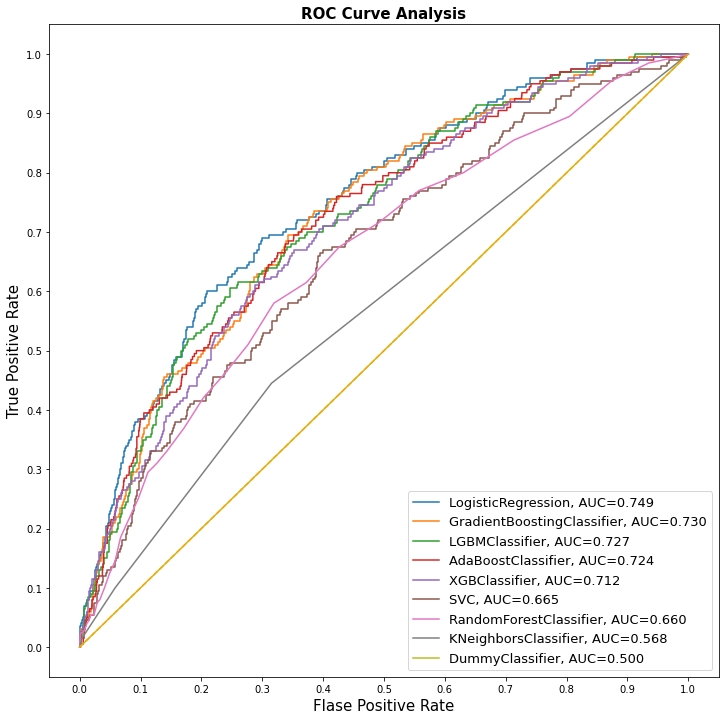

fpr  \
classifiers                                                                     
LogisticRegression          [0.0, 0.0, 0.0, 0.0004253509145044662, 0.00042...   
GradientBoostingClassifier  [0.0, 0.0, 0.0004253509145044662, 0.0004253509...   
LGBMClassifier              [0.0, 0.0, 0.0017014036580178648, 0.0017014036...   
AdaBoostClassifier          [0.0, 0.0004253509145044662, 0.001701403658017...   
XGBClassifier               [0.0, 0.0, 0.0, 0.0004253509145044662, 0.00042...   
SVC                         [0.0, 0.0, 0.0, 0.0017014036580178648, 0.00170...   
RandomForestClassifier      [0.0, 0.0004253509145044662, 0.000425350914504...   
KNeighborsClassifier        [0.0, 0.0038281582305401958, 0.058273075287111...   
DummyClassifier                                                    [0.0, 1.0]   

                                                                          tpr  \
classifiers                                                                     
LogisticRegression          [0.0, 0.005, 0.01, 0.01, 0.02, 0.02, 0.025, 0....   
GradientBoostingClassifier  [0.0, 0.005, 0.005, 0.015, 0.015, 0.02, 0.02, ...   
LGBMClassifier              [0.0, 0.005, 0.005, 0.015, 0.015, 0.02, 0.02, ...   
AdaBoostClassifier          [0.0, 0.0, 0.0, 0.005, 0.005, 0.015, 0.015, 0....   
XGBClassifier               [0.0, 0.005, 0.01, 0.01, 0.015, 0.015, 0.02, 0...   
SVC                         [0.0, 0.005, 0.01, 0.01, 0.015, 0.015, 0.025, ...   
RandomForestClassifier      [0.0, 0.0, 0.01, 0.01, 0.02, 0.025, 0.025, 0.0...   
KNeighborsClassifier                            [0.0, 0.015, 0.1, 0.445, 1.0]   
DummyClassifier                                                    [0.0, 1.0]   

                                 auc  
classifiers                           
LogisticRegression          0.748707  
GradientBoostingClassifier  0.729577  
LGBMClassifier              0.726621  
AdaBoostClassifier          0.724309  
XGBClassifier               0.711699  
SVC                         0.664692  
RandomForestClassifier      0.660421  
KNeighborsClassifier        0.567947  
DummyClassifier             0.500000

In [52]:
plot_roc_curve(default_models)

In [53]:
for model in default_models:
    print(type(model).__name__)
    evaluation(model)

DummyClassifier
[[2351    0]
 [ 200    0]]
AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2351
           1       0.00      0.00      0.00       200

    accuracy                           0.92      2551
   macro avg       0.46      0.50      0.48      2551
weighted avg       0.85      0.92      0.88      2551

LogisticRegression
[[2346    5]
 [ 193    7]]
AUC : 0.7487
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2351
           1       0.58      0.04      0.07       200

    accuracy                           0.92      2551
   macro avg       0.75      0.52      0.51      2551
weighted avg       0.90      0.92      0.89      2551

KNeighborsClassifier
[[2342    9]
 [ 197    3]]
AUC : 0.5679
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2351
           1       0.25      0.01      0.03       200

    ac

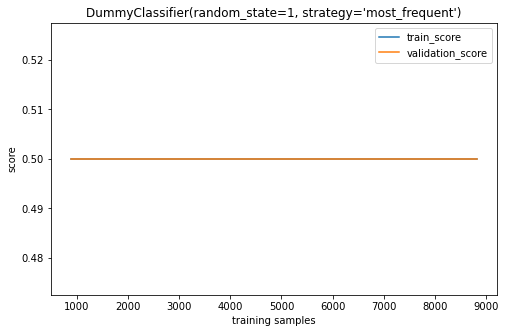

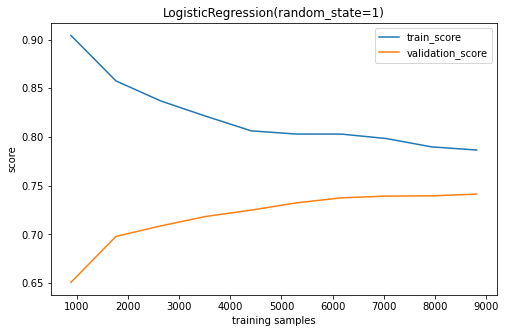

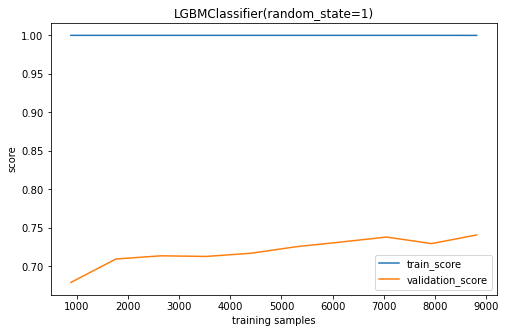

Wall time: 1min 1s


In [54]:
%%time
models_for_curve = [
    DummyClassifier(strategy='most_frequent', random_state=1),
    LogisticRegression(random_state=1), 
    LGBMClassifier(random_state=1)
]  
for model in models_for_curve : 
    learn_curve(model, X_train, y_train)

# Hyperparameter tuning

## Without class balancing

In [55]:
def search_best_score(model , params, business_metric=True, grid=True):

    """"""
    
    if grid : 
        if business_metric : 
            print('F5 score...')
            f5_scorer = make_scorer(fbeta_score, beta=5)
            search = GridSearchCV(model, params, scoring=f5_scorer, cv=cv)
      
        else :
            print('AUC_ROC score...')
            search = GridSearchCV(model, params, scoring='roc_auc', cv=cv)
  
       
    else :
        if business_metric : 
            print('F5 score...')
            f5_scorer = make_scorer(fbeta_score, beta=5)
            search = RandomizedSearchCV(model, params, scoring=f5_scorer, cv=cv)
      
        else :
            print('AUC_ROC score...')
            search = RandomizedSearchCV(model, params, scoring='roc_auc', cv=cv)
        
         # To train model
    search.fit(X_train, y_train) 
    print(search.best_params_)
    print(model)    
    print ("Train score : %.4f"%search.best_estimator_.score(X_train, y_train))
    print ("Best (validation) score is : %.4f"%search.best_score_)
    print ("test score :%.4f"%search.best_estimator_.score(X_test , y_test)) 
    print("\n")
           
    return search.best_estimator_


In [56]:
lgbm = LGBMClassifier(random_state=1)
log_reg = LogisticRegression(random_state=1)

In [57]:
lgbm_params = {
    'max_depth'         : [3],
    'num_leaves'        : range(2,3),
    #'max_bin'           : range(500,700,100),
}
    #'min_child_samples' : range(300,400,100),
    #'n_estimators'      : range(100,110,10),
    #'n_estimators'      : [5000]
    #'learning_rat     : [0.01,0.02,0.05],
    #'class_weight'    : [{0:x, 1:1.0-x} for x in  np.linspace(0.0,8,20)]
    #'reg_alpha'       : [0.1, 0.2],
    #'reg_lambda'      : [50, 100,150],
    #'min_data_in_leaf': range(100,500,100)
    

log_reg_params = {'C' : [150, 100, 10, 1.0, 0.1, 0.01]}

In [58]:
%%time
best_business_lgbm = search_best_score(lgbm, lgbm_params, business_metric=True, grid=False)
best_business_lgbm

F5 score...
{'num_leaves': 2, 'max_depth': 3}
LGBMClassifier(random_state=1)
Train score : 0.9190
Best (validation) score is : 0.0013
test score :0.9216


Wall time: 1.76 s


LGBMClassifier(max_depth=3, num_leaves=2, random_state=1)

In [59]:
%%time
best_technic_lgbm = search_best_score(lgbm, lgbm_params, business_metric=False, grid=False)
best_technic_lgbm

AUC_ROC score...
{'num_leaves': 2, 'max_depth': 3}
LGBMClassifier(random_state=1)
Train score : 0.9190
Best (validation) score is : 0.7497
test score :0.9216


Wall time: 1.76 s


LGBMClassifier(max_depth=3, num_leaves=2, random_state=1)

In [60]:
%%time
#best_business_lr = search_best_score(log_reg, log_reg_params, business_metric=True, grid=False)
#best_business_lr

Wall time: 0 ns


In [61]:
%%time
#best_technic_lr = search_best_score(log_reg, log_reg_params, business_metric=False, grid=False)
#best_technic_lr

Wall time: 0 ns


In the next part, classes will be balanced

## Hyperparameter tuning-handling class imbalance with class weight

In [62]:
print('class weihgts are :',class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train))  
lgbm = LGBMClassifier(class_weight='balanced', random_state=1)
log_reg = LogisticRegression(class_weight='balanced', random_state=1)

class weihgts are : [0.54414705 6.16289308]


In [63]:
beta = 5
def cross_validate(classifier, X, y, beta=beta, flag_trade=True):
    
    
    train_score, val_score = [], []
    for train_idx, val_idx in cv.split(X,y) : 
        #X_res, y_res = SMOTE().fit_resample(X[train_idx], y[train_idx])
        X_res, y_res = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        f5_scorer = make_scorer(fbeta_score, beta=5)
        classifier.fit(X_res, y_res)
        
        if not flag_trade : 
            val_score.append(roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1]))
            train_score.append(roc_auc_score(y_res, classifier.predict_proba(X_res)[:,1]))
        else :
            val_score.append(fbeta_score(y_val, classifier.predict(X_val), beta=beta))
            train_score.append(fbeta_score(y_res, classifier.predict(X_res), beta=beta))
    return val_score, train_score    

def grid_search(classifier, params, X, y, flag_trade=True):
    val_best_score = 0
    param_list = list(ParameterSampler(params, random_state=1, n_iter=100))
    for param_grid in tqdm(param_list):
        classifier.set_params(**param_grid)
        val_score, train_score = cross_validate(classifier, X, y, beta, flag_trade=flag_trade)
        train_mean_score = np.array(train_score).mean()
        val_mean_score = np.array(val_score).mean()
        
        if val_mean_score > val_best_score : 
            val_best_score = val_mean_score
            best_estimator = classifier
            classifier.predict(X_test)
            test_score = fbeta_score(y_test, classifier.predict(X_test), beta=5)
    print(best_estimator)        
    print(' train score ', train_mean_score)
    print('\n val score', val_best_score)
    print('\n test score', test_score)
          
    return best_estimator, val_best_score, val_mean_score, train_mean_score
        

In [64]:
%%time
print('best results of LGBMClassifier with F5 score')
best_estimator_lgbm_business, val_best_score, val_mean_score, train_mean_score = grid_search(
    lgbm,
    lgbm_params, 
    X_train,
    y_train,
    flag_trade=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

best results of LGBMClassifier with F5 score


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=2,
               random_state=1)
 train score  0.6307457775949432

 val score 0.5883617189821428

 test score 0.556341673856773
Wall time: 1.67 s


In [65]:
%%time
print('best results of LGBMClassifier with ROC_AUC score')
best_estimator_lgbm_tech, val_best_score, val_mean_score, train_mean_score = grid_search(
    lgbm,
    lgbm_params, 
    X_train,
    y_train,
    flag_trade=False)

  0%|          | 0/1 [00:00<?, ?it/s]

best results of LGBMClassifier with ROC_AUC score


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=2,
               random_state=1)
 train score  0.7810038698047561

 val score 0.7484405053437265

 test score 0.556341673856773
Wall time: 1.66 s


In [66]:
print('best results of logistic regression with F5 score')
best_estimator_lr_business, val_best_score, val_mean_score, train_mean_score = grid_search(
    log_reg,
    log_reg_params, 
    X_train,
    y_train, 
    flag_trade=True)

  0%|          | 0/6 [00:00<?, ?it/s]

best results of logistic regression with F5 score


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]

LogisticRegression(C=0.01, class_weight='balanced', random_state=1)
 train score  0.6325518209077139

 val score 0.5801096658340722

 test score 0.6026930288051815


In [67]:
print('best results of logistic regression with ROC_AUC score')
best_estimatorlr_tech, val_best_score, val_mean_score, train_mean_score = grid_search(
    log_reg,
    log_reg_params, 
    X_train,
    y_train, 
    flag_trade=False)

  0%|          | 0/6 [00:00<?, ?it/s]

best results of logistic regression with ROC_AUC score


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]

LogisticRegression(C=0.01, class_weight='balanced', random_state=1)
 train score  0.7685152090284211

 val score 0.7379491501667939

 test score 0.5857265692175408


In [68]:
def best_class_weight(classifier): 
    
    
    #Set the range of class weights
    weights = np.linspace(0,0.99,20)
    #Create dictionary grid for grid search
    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

    ##Fitting training data with 5 times grid search method
    f5_scorer = make_scorer(fbeta_score, beta=5)
    gridsearch = GridSearchCV(estimator= classifier, 
                          param_grid= param_grid,
                          cv=cv, 
                          n_jobs=-1, 
                          scoring=f5_scorer, 
                          verbose=2)
    
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    print ("Train score : %.4f"%gridsearch.best_estimator_.score(X_train, y_train))
    print ("Best (validation) score is : %.4f"%gridsearch.best_score_)
    print ("test score :%.4f"%gridsearch.best_estimator_.score(X_test , y_test))

    #Draw fractions with different weight values
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,8))
    weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
    sns.lineplot(weigh_data['weight'], weigh_data['score'])
    plt.xlabel('Weight for class 1')
    plt.ylabel('F1 score')
    plt.xticks([round(i/10,1) for i in range(0,11,1)])
    plt.title('Scoring for different class weights', fontsize=24)
    return gridsearch.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'class_weight': {0: 0.0, 1: 1.0}}
Train score : 0.0811
Best (validation) score is : 0.6966
test score :0.0784
[[   0 2351]
 [   0  200]]
AUC : 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2351
           1       0.08      1.00      0.15       200

    accuracy                           0.08      2551
   macro avg       0.04      0.50      0.07      2551
weighted avg       0.01      0.08      0.01      2551

Wall time: 55.5 s


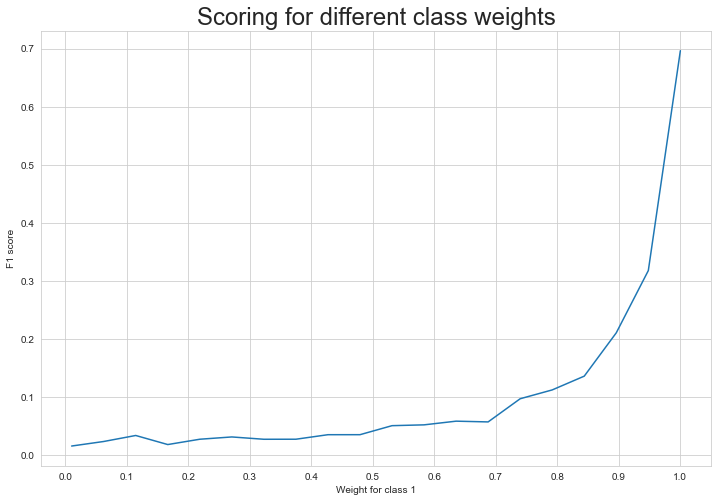

In [69]:
%%time
best_lgbm_weight = best_class_weight(LGBMClassifier(random_state=1))
LGBM = LGBMClassifier(class_weight=best_lgbm_weight['class_weight'], random_state=1)
evaluation(LGBM)

# SMOTE 

In [80]:
%%time
from imblearn.pipeline import Pipeline
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LGBMClassifier(random_state=1))
    ])


params = {
    'classification__max_depth'         : [4],
    'classification__num_leaves'        : [2],
    #'classification__min_child_samples' : range(300,400,100),
    'classification__n_estimators'      : [200,100],
    #'classification__max_bin'           : range(500,700,100), 
    
}
f5_score = make_scorer(fbeta_score, beta=beta) 
    
grid = GridSearchCV(
    model,
    params,
    cv=cv, 
    scoring=f5_score
)
grid.fit(X_train, y_train)

print(grid.best_params_)    
print('train score',grid.best_estimator_.score(X_train,y_train))
print('validation score',grid.best_score_)
print('test score',grid.best_estimator_.score(X_test, y_test))
    

{'classification__max_depth': 4, 'classification__n_estimators': 100, 'classification__num_leaves': 2}
train score 0.836411878763139
validation score 0.3073071611684985
test score 0.8345746765974128
Wall time: 10.9 s


# Global Interpreting

In [81]:
best_estimator_lgbm_business

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=2,
               random_state=1)

In [87]:
print(fbeta_score(y_train, best_estimator_lgbm_business.predict(X_train), beta=5))
predicted = best_estimator_lgbm_business.predict(X_test)
fbeta_score(y_test, predicted, beta=5)

0.6256320836965998


0.556341673856773

In [88]:
def cf_matrix_roc_auc(X_train, X_test, y_train, y_test, model):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.legend()
    plt.show()

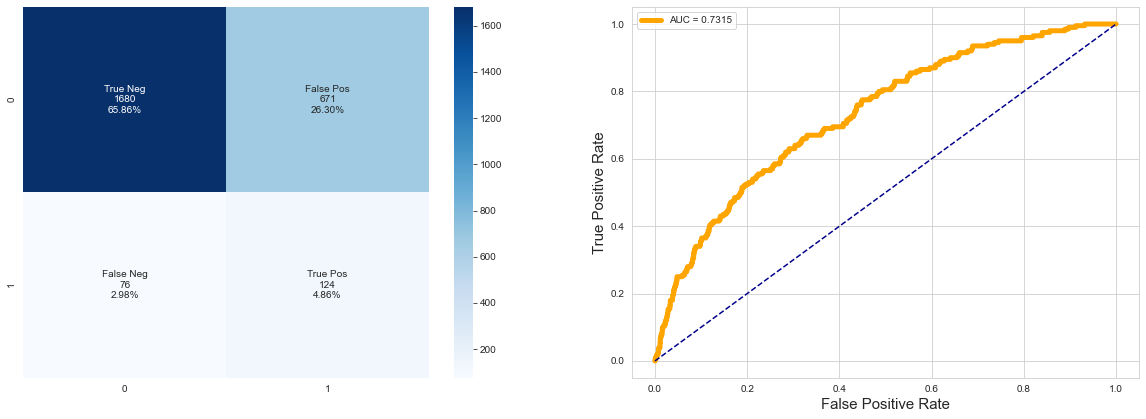

In [89]:
cf_matrix_roc_auc(X_train, X_test, y_train, y_test, best_estimator_lgbm_business)

In [92]:
evaluation(best_estimator_lgbm_business)

[[1685  666]
 [  80  120]]
AUC : 0.7332
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2351
           1       0.15      0.60      0.24       200

    accuracy                           0.71      2551
   macro avg       0.55      0.66      0.53      2551
weighted avg       0.89      0.71      0.77      2551



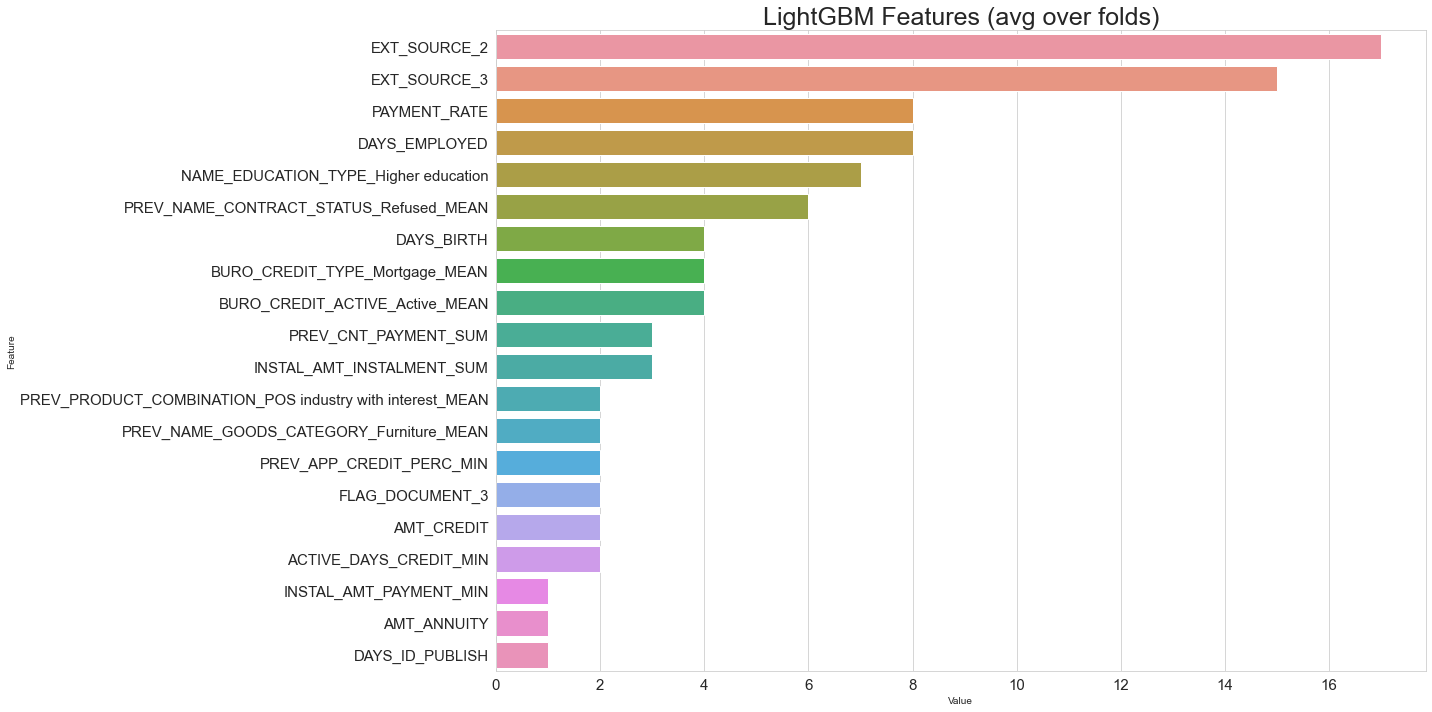

In [91]:
feat_imp_columns = train_set.drop(columns='TARGET', axis=1).columns
feature_imp = pd.DataFrame(sorted(zip(best_estimator_lgbm_business.feature_importances_,feat_imp_columns)), columns=['Value','Feature'])
feature_imp.sort_values(by='Value', ascending=False, inplace=True)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.iloc[:20,:])
plt.title('LightGBM Features (avg over folds)', size=25)
plt.xticks(size=15)
plt.yticks(size=15)

plt.tight_layout()
plt.show()


In [ ]:
# permutation feature importance??

In [127]:
from sklearn.feature_selection import SelectFromModel
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel(best_estimator_lgbm_business, max_features=20)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    #selected_features = fs.feature_names_in_
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
best_estimator_lgbm_business.fit(X_train_fs, y_train)
# evaluate the model
yhat = best_estimator_lgbm_business.predict(X_test_fs)
# evaluate predictions
f5_train = fbeta_score(y_train, best_estimator_lgbm_business.predict(X_train_fs), beta=5)
f5_test = fbeta_score(y_test, yhat, beta=5)
print('F5_train: %.2f' % (f5_train*100))
print('F5_test: %.2f' % (f5_test*100))


F5_train: 62.92
F5_test: 55.21


# Save the Model with pickle

Pickle is the standard way of serializing objects in Python.

You can use the pickle operation to serialize your machine learning algorithms and save the serialized format to a file.

Later you can load this file to deserialize your model and use it to make new predictions.

In [100]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(best_estimator_lgbm_business, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

LGBMClassifier(class_weight='balanced', max_depth=3, num_leaves=2,
               random_state=1)

# Local interpreting

In [101]:
#!pip install lime
from lime import lime_tabular

In [131]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_fs,
    feature_names=list(feature_imp.iloc[:20,1]),
    class_names=[0,1],
    mode='classification',
    verbose=True,
    random_state=1 
)

In [132]:
idx = np.random.randint(0, len(y_test))
print(idx)
print("Prediction : ", (loaded_model.predict(X_test_fs))[idx])
print("Actual :     ", y_test[idx])
explanation = lime_explainer.explain_instance(
    data_row=X_test_fs[idx],
    predict_fn=loaded_model.predict_proba,
    num_features=20)

explanation

2093
Prediction :  1
Actual :      0
Intercept 0.3360066681037344
Prediction_local [0.46163028]
Right: 0.5513504741515654


In [133]:
explanation.show_in_notebook()

<Figure size 720x720 with 0 Axes>

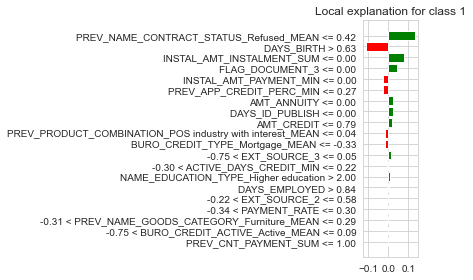

In [134]:
plt.figure(figsize=(10,10))
explanation.as_pyplot_figure()
plt.tight_layout()

Negative correlation are explained in RED
Positive correlatio are shown in green
Next lets export coefficients to understans each features' contribution to the output

In [135]:
coefs = pd.DataFrame(explanation.as_list())[1].sum()
print('sum of coefs and intercept is :', coefs + 0.3360066681037344)
pd.DataFrame(explanation.as_list())

sum of coefs and intercept is : 0.461630283927156


0         1
0      PREV_NAME_CONTRACT_STATUS_Refused_MEAN <= 0.42  0.134105
1                                   DAYS_BIRTH > 0.63 -0.112812
2                   INSTAL_AMT_INSTALMENT_SUM <= 0.00  0.080469
3                             FLAG_DOCUMENT_3 <= 0.00  0.044246
4                      INSTAL_AMT_PAYMENT_MIN <= 0.00 -0.026200
5                    PREV_APP_CREDIT_PERC_MIN <= 0.27 -0.024925
6                                 AMT_ANNUITY <= 0.00  0.021774
7                             DAYS_ID_PUBLISH <= 0.00  0.021168
8                                  AMT_CREDIT <= 0.79  0.019852
9   PREV_PRODUCT_COMBINATION_POS industry with int... -0.019347
10            BURO_CREDIT_TYPE_Mortgage_MEAN <= -0.33 -0.017355
11                       -0.75 < EXT_SOURCE_3 <= 0.05  0.010860
12             -0.30 < ACTIVE_DAYS_CREDIT_MIN <= 0.22 -0.007839
13        NAME_EDUCATION_TYPE_Higher education > 2.00  0.006863
14                               DAYS_EMPLOYED > 0.84  0.004067
15                       -0.22 < EXT_SOURCE_2 <= 0.58 -0.003534
16                       -0.34 < PAYMENT_RATE <= 0.30 -0.002730
17  -0.31 < PREV_NAME_GOODS_CATEGORY_Furniture_MEA... -0.002305
18     -0.75 < BURO_CREDIT_ACTIVE_Active_MEAN <= 0.09 -0.000734
19                       PREV_CNT_PAYMENT_SUM <= 1.00  0.000000

In [136]:
#!pip install shap
import shap

In [137]:
shap_explainer = shap.TreeExplainer(loaded_model)
shap_explainer

In [138]:
shap_values = shap_explainer.shap_values(X_test_fs)
shap_values

[array([[-0.00683187,  0.12451674,  0.31218739, ..., -0.23476307,
         -0.00857512, -0.0139947 ],
        [-0.00683187, -0.03939238, -0.01299379, ..., -0.23476307,
         -0.00857512, -0.0139947 ],
        [-0.00683187,  0.12451674, -0.01299379, ...,  0.04437592,
         -0.00857512, -0.0139947 ],
        ...,
        [-0.00683187, -0.03939238, -0.01299379, ...,  0.04437592,
         -0.00857512, -0.0139947 ],
        [-0.00683187,  0.12451674, -0.12836766, ...,  0.04437592,
         -0.00857512, -0.0139947 ],
        [-0.00683187, -0.03939238, -0.01299379, ...,  0.04437592,
         -0.00857512, -0.0139947 ]]),
 array([[ 0.00683187, -0.12451674, -0.31218739, ...,  0.23476307,
          0.00857512,  0.0139947 ],
        [ 0.00683187,  0.03939238,  0.01299379, ...,  0.23476307,
          0.00857512,  0.0139947 ],
        [ 0.00683187, -0.12451674,  0.01299379, ..., -0.04437592,
          0.00857512,  0.0139947 ],
        ...,
        [ 0.00683187,  0.03939238,  0.01299379, ..., -

In [139]:
#Initilize javascript in cell
shap.initjs()

In [140]:
shap.force_plot(
    shap_explainer.expected_value[1],
    shap_values[1][0],
    X_test_fs[idx],
    feature_names=list(feature_imp.iloc[:20,1])
)

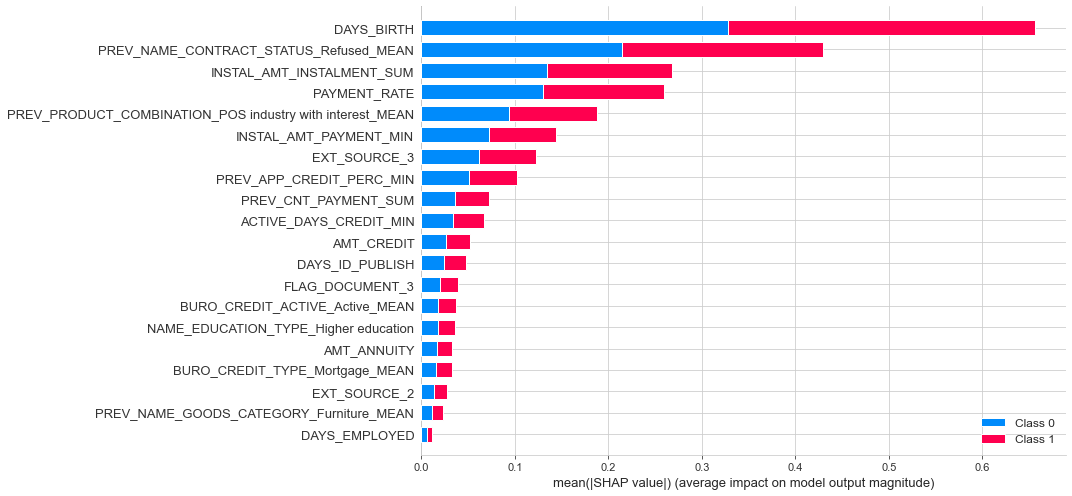

In [142]:
shap.initjs()
shap.summary_plot(shap_values, X_test_fs, feature_names=list(feature_imp.iloc[:20,1]), max_display=20, plot_size=(15,7))

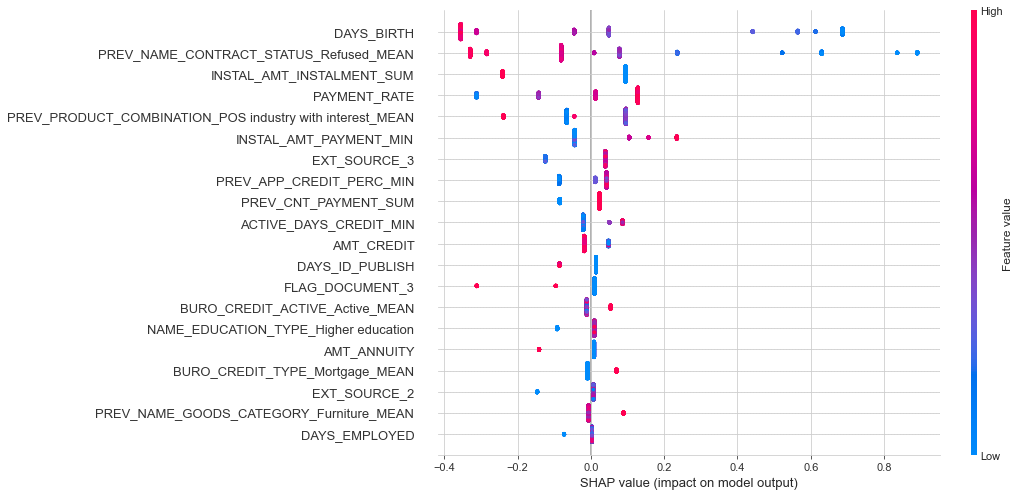

In [143]:
shap.initjs()
shap.summary_plot(shap_values[1], X_test_fs, feature_names=list(feature_imp.iloc[:20,1]), max_display=20, plot_size=(15,7))